# 케라스 전이 학습(Transfer Learning)

<img src="https://miro.medium.com/max/5252/1*Z11P-CjNYWBofEbmGQrptA.png">

<sub>출처: https://medium.com/the-official-integrate-ai-blog/transfer-learning-explained-7d275c1e34e2</sub>


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *

In [2]:
vgg16 = VGG16(weights='imagenet',
              input_shape=(32, 32, 3), include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


In [3]:
model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                        

In [4]:
mobilenet = MobileNet(weights=None, input_shape=None, include_top=True)

resnet = ResNet50(weights=None, input_shape=None, include_top=True)

xception = Xception(weights=None, input_shape=None, include_top=True)

<br>

### 예제 : Dogs vs Cats
- Kaggle Data 이용: https://www.kaggle.com/c/dogs-vs-cats/data

- ImageDataGenerator의 flow_from_directory 이용

- 런타임 유형 GPU 사용

- 출처: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb#scrollTo=SdW6geEVi2S8

#### modules import

In [5]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Input, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

<br>

#### 데이터 로드

In [8]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
  /content/cats_and_dogs_filtered.zip

--2023-06-06 09:15:57--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M  29.1MB/s    in 2.2s    

2023-06-06 09:16:00 (29.1 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [12]:
local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [15]:
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [16]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

val_cats_dir = os.path.join(validation_dir, 'cats')
val_dogs_dir = os.path.join(validation_dir, 'dogs')

In [19]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

<br>

#### 이미지 보강된 데이터 확인

In [21]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

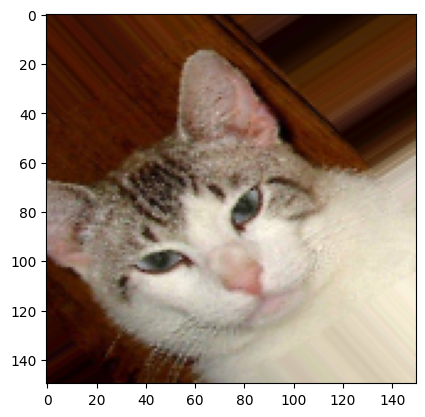

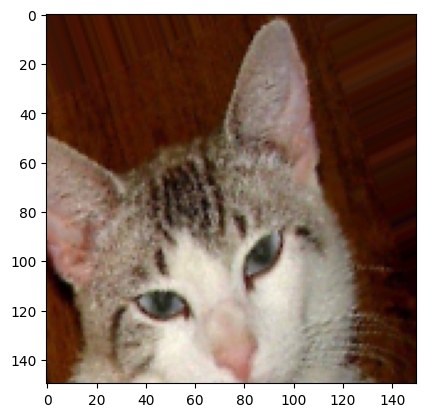

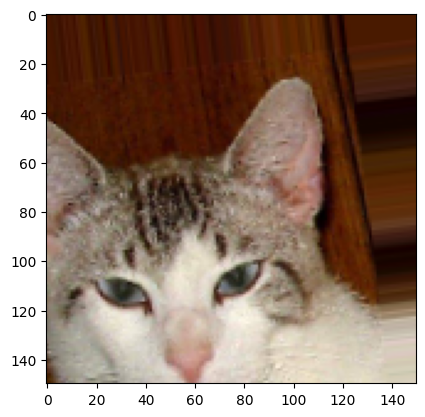

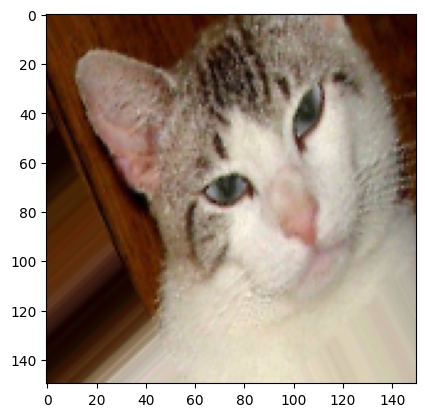

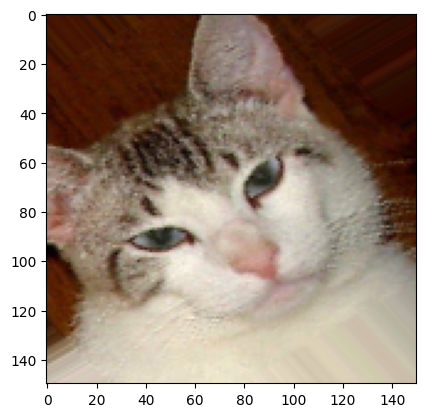

In [22]:
img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = x.reshape((1, ) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure()
  imgplot = plt.imshow(array_to_img(batch[0]))

  i += 1
  if i % 5 ==0:
    break

<br>

#### 학습, 검증 데이터셋의 Data Generator

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<br>

#### 모델 구성 및 컴파일

In [27]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

<br>

#### 모델 학습 및 학습 과정 시각화
- 런타임유형 GPU 사용

In [28]:
history = model.fit(train_generator,
                    steps_per_epoch=100, epochs=30,
                    batch_size=256, validation_data=validation_generator,
                    validation_steps=50,
                    verbose=False)

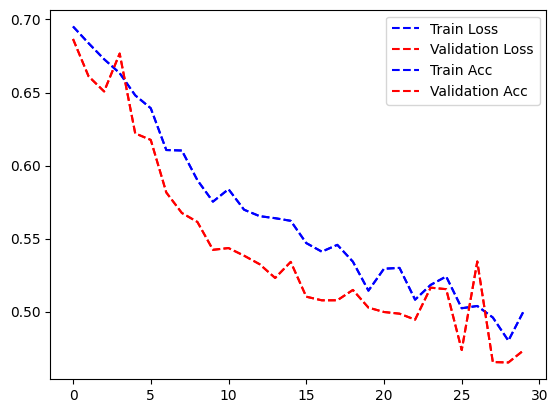

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b--', label='Train Acc')
plt.plot(epochs, val_loss, 'r--', label='Validation Acc')
plt.grid()
plt.legend()

plt.show()

<br>

#### 모델 저장

In [30]:
model.save('cats_and_dogs_model.h5')

<br>

<br>

### 사전 훈련된 모델 사용

In [33]:
from tensorflow.keras.optimizers import RMSprop

In [31]:
conv_base = VGG16(weights='imagenet',
                  input_shape=(150, 150, 3), include_top=False)

In [32]:
def build_model_with_pretrained(conv_base):
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=2e-5),
                metrics=['acc'])
  
  return model

<br>

파라미터의 수 확인!

In [34]:
model = build_model_with_pretrained(conv_base)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


<br>

#### 레이어 동결
- 훈련하기 전, 합성곱 기반 레이어들의 가중치 학습을 막기 위해 이를 동결

In [35]:
print(len(model.trainable_weights))

30


In [36]:
conv_base.trainable = False

In [37]:
print(len(model.trainable_weights))

4


<br>

#### 모델 컴파일
- trainable 속성을 변경했기 때문에 다시 모델을 컴파일 해야함

In [38]:
model.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=2e-5),
                metrics=['acc'])

<br>

#### 이미지 제너레이터

In [39]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<br>

#### 모델 재학습

In [40]:
history = model.fit(train_generator,
                    steps_per_epoch=100, epochs=30,
                    batch_size=256, validation_data=validation_generator,
                    validation_steps=50,
                    verbose=False)

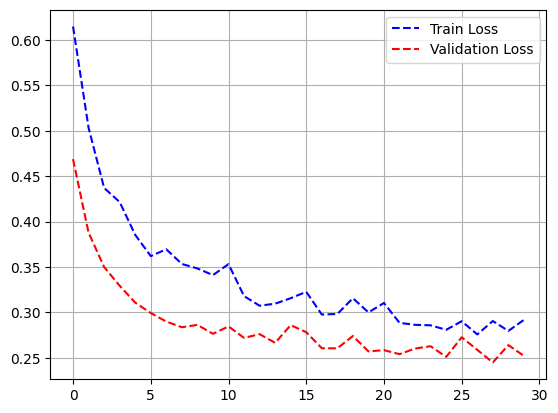

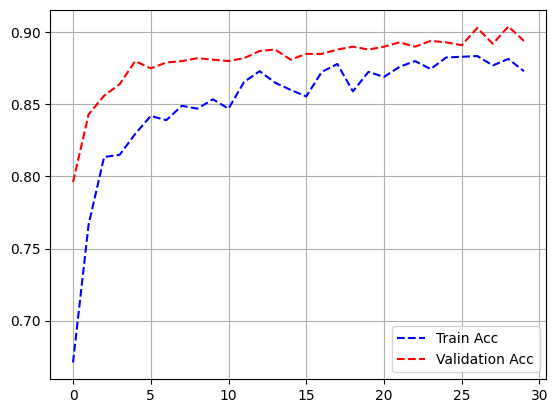

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Train Acc')
plt.plot(epochs, val_acc, 'r--', label='Validation Acc')
plt.grid()
plt.legend()

plt.show()

<br>

#### 모델 저장

In [42]:
model.save('cats_and_dogs_with_pretrained_model.h5')

<br>

<br>

## Feature Map 시각화

In [45]:
import numpy as np
from tensorflow.keras.models import load_model

<br>

### 모델 구성

In [69]:
model = load_model('/content/cats_and_dogs_model.h5')

In [70]:
img_path = '/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg'

img = load_img(img_path, target_size=(150, 150))
img_tensor = img_to_array(img)
img_tensor = img_tensor[np.newaxis, ...]
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


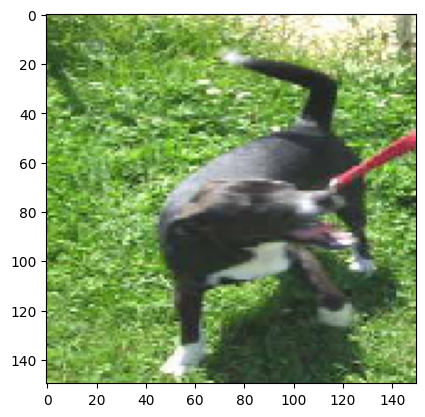

In [71]:
plt.imshow(img_tensor[0])
plt.show()

In [73]:
conv_output = [layer.output for layer in model.layers[:8]]
conv_output

[<KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d_8')>,
 <KerasTensor: shape=(None, 74, 74, 32) dtype=float32 (created by layer 'max_pooling2d_4')>,
 <KerasTensor: shape=(None, 72, 72, 64) dtype=float32 (created by layer 'conv2d_9')>,
 <KerasTensor: shape=(None, 36, 36, 64) dtype=float32 (created by layer 'max_pooling2d_5')>,
 <KerasTensor: shape=(None, 34, 34, 128) dtype=float32 (created by layer 'conv2d_10')>,
 <KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'max_pooling2d_6')>,
 <KerasTensor: shape=(None, 15, 15, 128) dtype=float32 (created by layer 'conv2d_11')>,
 <KerasTensor: shape=(None, 7, 7, 128) dtype=float32 (created by layer 'max_pooling2d_7')>]

In [74]:
activation_model = Model(inputs=[model.input], outputs=conv_output)

In [75]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 87ms/step


In [76]:
len(activations)

8

<br>

### 시각화

(1, 148, 148, 32)


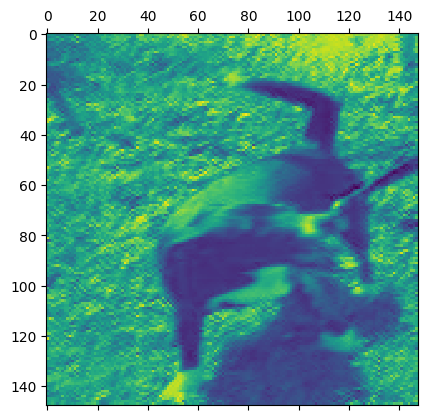

In [78]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 8], cmap='viridis')
plt.show()

(1, 148, 148, 32)


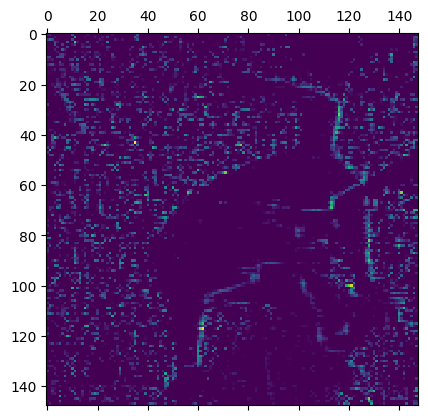

In [79]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 10], cmap='viridis')
plt.show()

(1, 148, 148, 32)


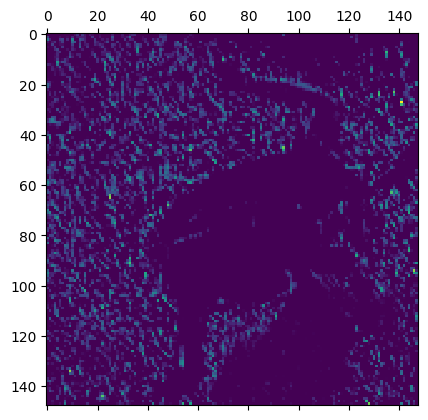

In [80]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 20], cmap='viridis')
plt.show()

<br>

### 중간의 모든 활성화에 대해 시각화

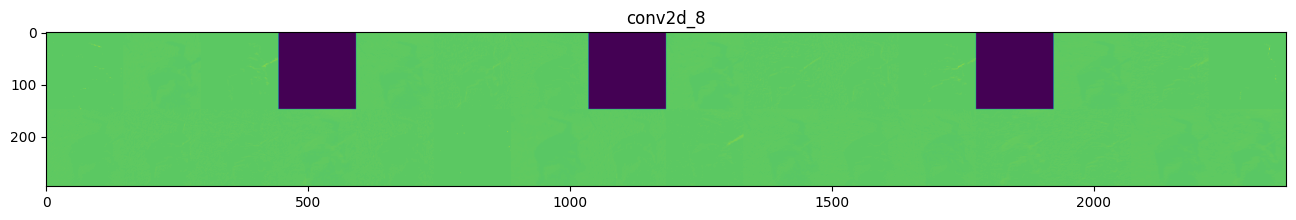

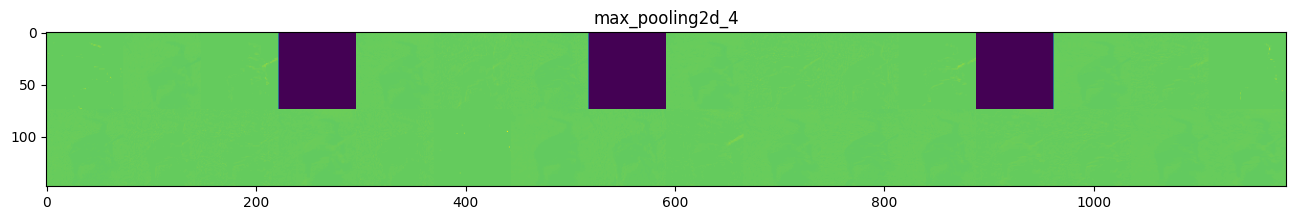

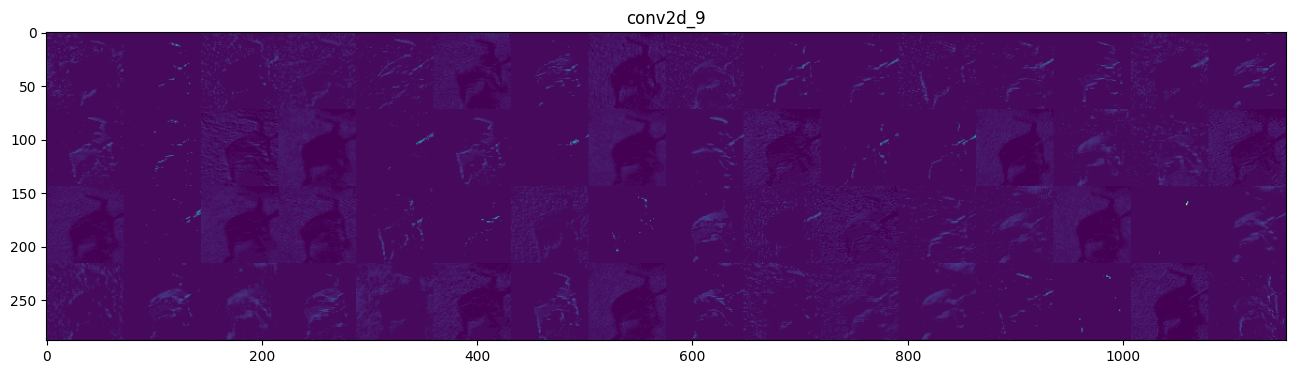

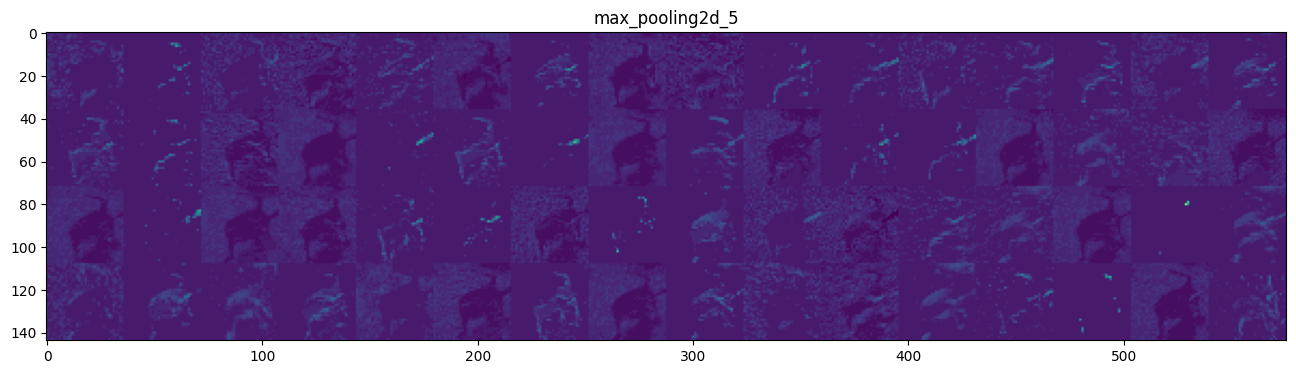

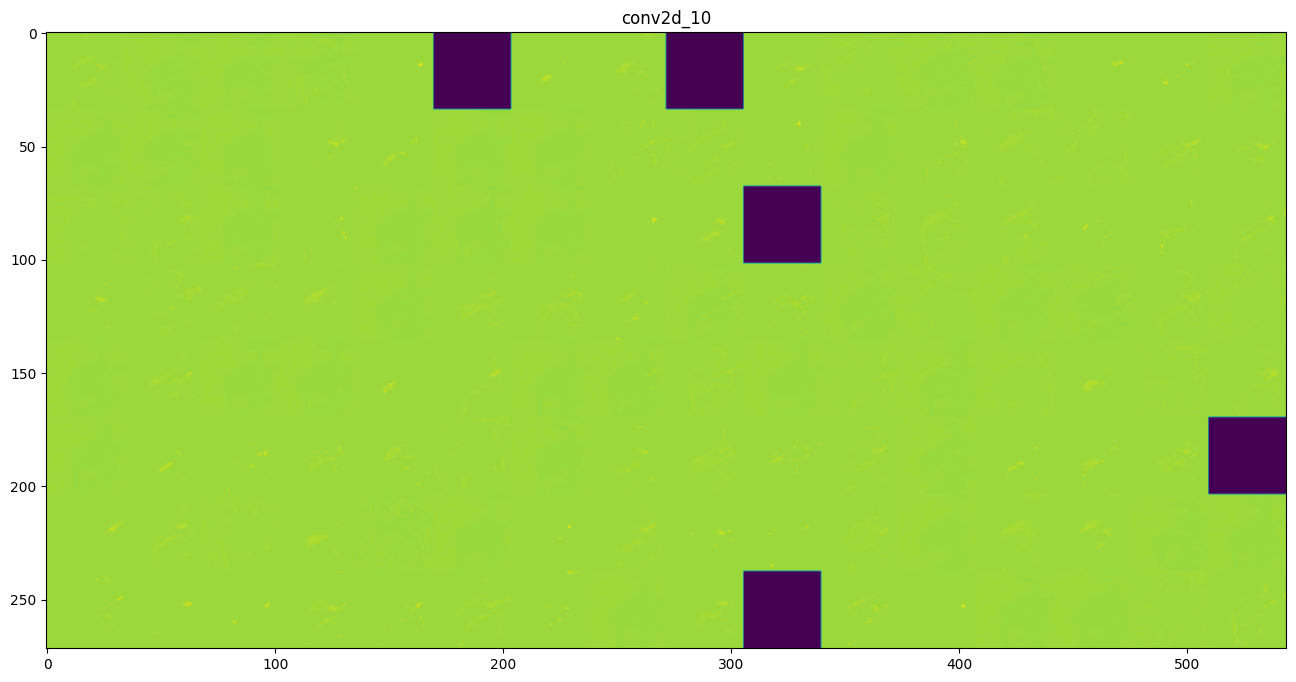

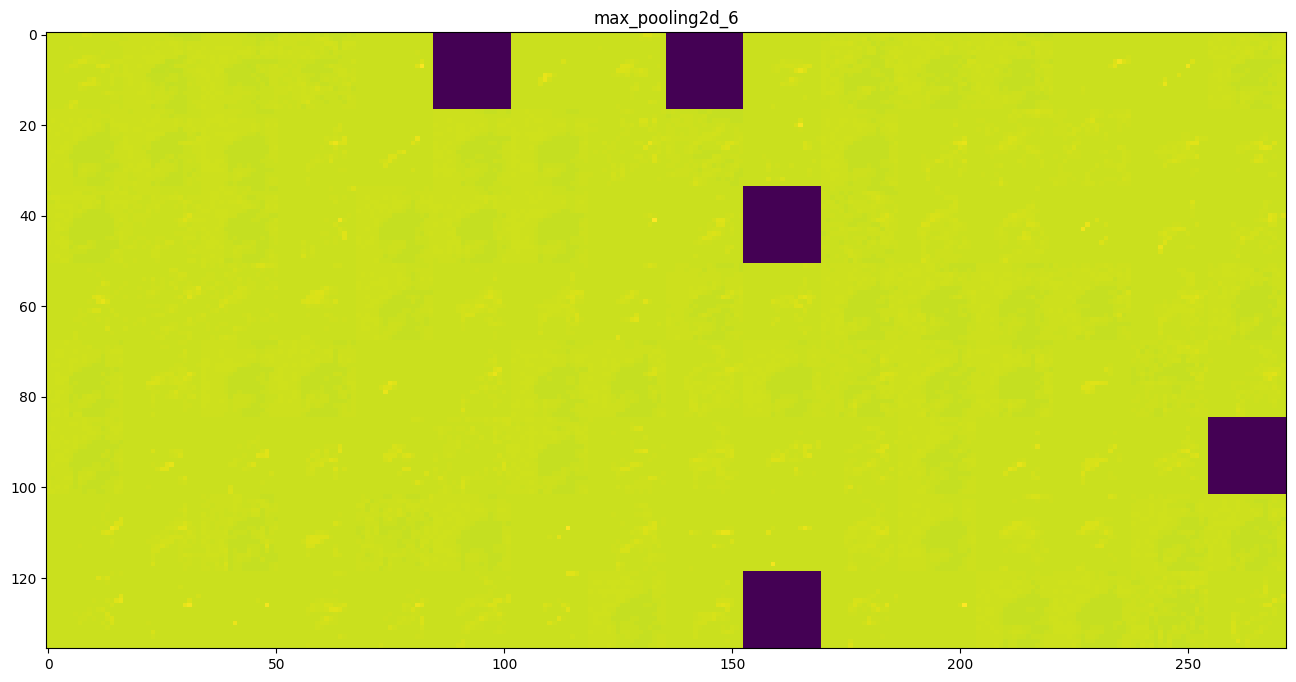

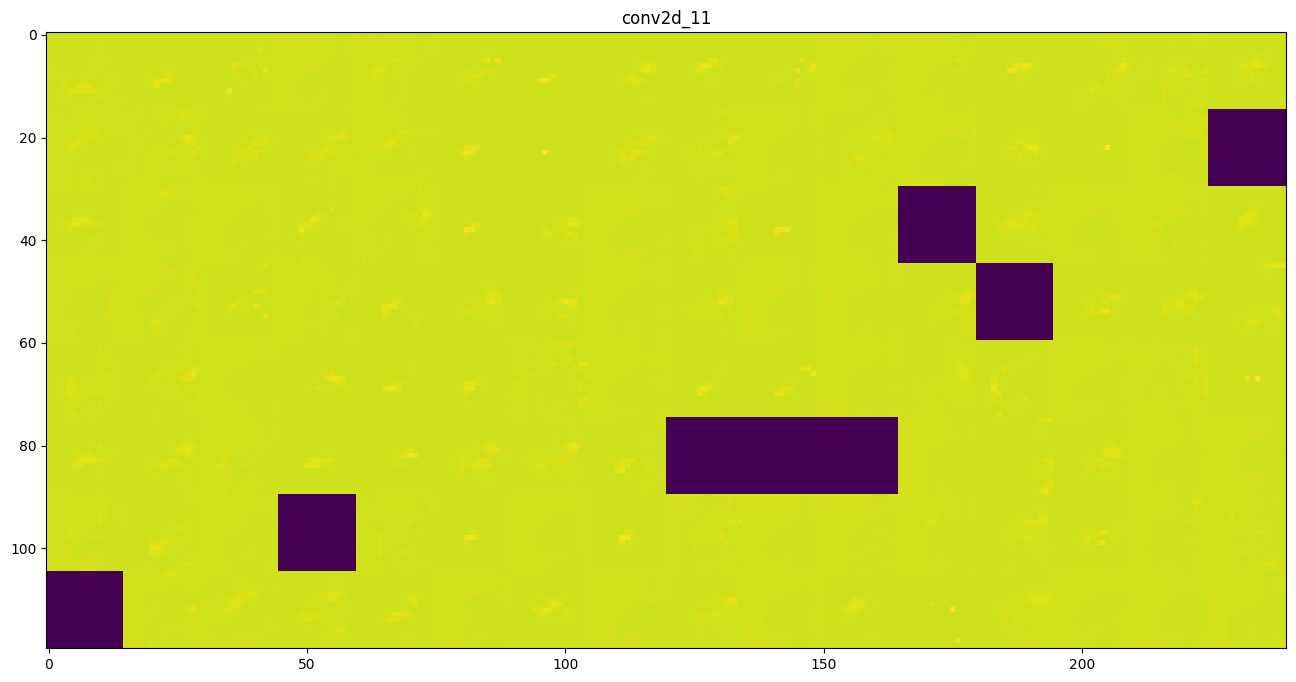

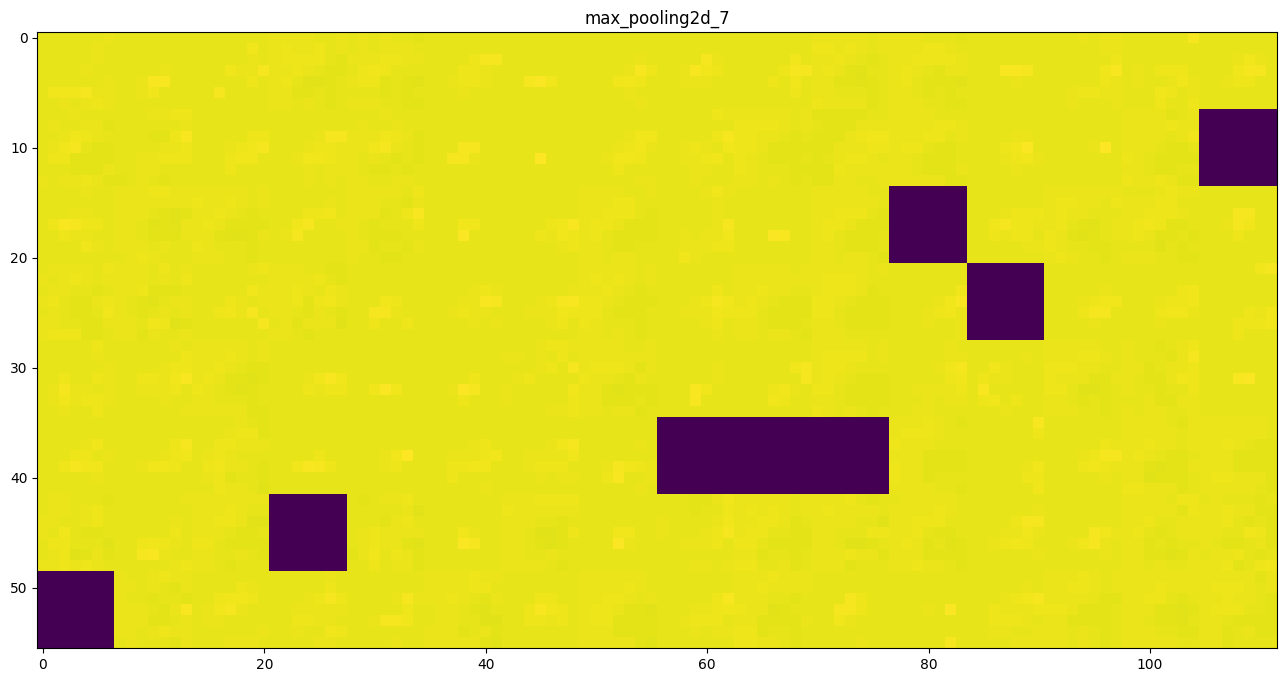

In [82]:
layer_names = []

for layer in model.layers[:8]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  num_features = layer_activation.shape[-1]

  size = layer_activation.shape[1]

  num_cols = num_features // images_per_row
  display_grid = np.zeros((size * num_cols, images_per_row * size))

  for col in range(num_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image += 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size: (col+1) * size, row * size : (row+1) * size] = channel_image

  scale = 1. / size

  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()